# SHAP Local Explanation

In [1]:
import os
import warnings
from pathlib import Path

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

from src.utils.models_pkl import load_pickle
from src.modeling.create_data_split import split_data
from src.explanation.local.utils import plot_bar, plot_scatter
from src.explanation.local.shap_explainer import ShapExplainer
from config.config_modeling import CAT_COLS, TRAIN_SIZE, TEST_FROM_VAL, RANDOM_STATE

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Notebook settings

In [2]:
warnings.filterwarnings("ignore")

## Define constants

In [3]:
# Paths.
IN_PATH = Path(os.path.join("..", "..", "data")) / "data_plain.csv"
MODEL_PATH = Path(os.path.join("..", "..", "models")) / "XGB.pkl"

## Load data

In [4]:
data = split_data(
    cols=CAT_COLS,
    df=pd.read_csv(IN_PATH),
    train_size=TRAIN_SIZE,
    test_size=TEST_FROM_VAL,
    random_state=RANDOM_STATE,
)

X_train, Y_train = data["train"]
X_train.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)

X_test, Y_test = data["test"]
X_test.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)

## Load model

In [5]:
model = load_pickle(MODEL_PATH)

# Validate model and data.
print(roc_auc_score(Y_train, model.predict_proba(X_train)[:, 1]))
print(roc_auc_score(Y_test, model.predict_proba(X_test)[:, 1]))

0.8977178819987657
0.8601132732283131


## SHAP Local Explanation

### Define SHAP Explainer

In [6]:
def prediction_function(x: pd.DataFrame) -> np.ndarray:
    predictions = model.predict_proba(x)[:, 1]
    return predictions


shap_explainer = ShapExplainer(prediction_function=prediction_function, dataset=X_train)

### Global explanation

In [7]:
res = shap_explainer.get_global_explanation(X_test[:1000], normalize=True)

100%|██████████| 1000/1000 [00:45<00:00, 22.03it/s]


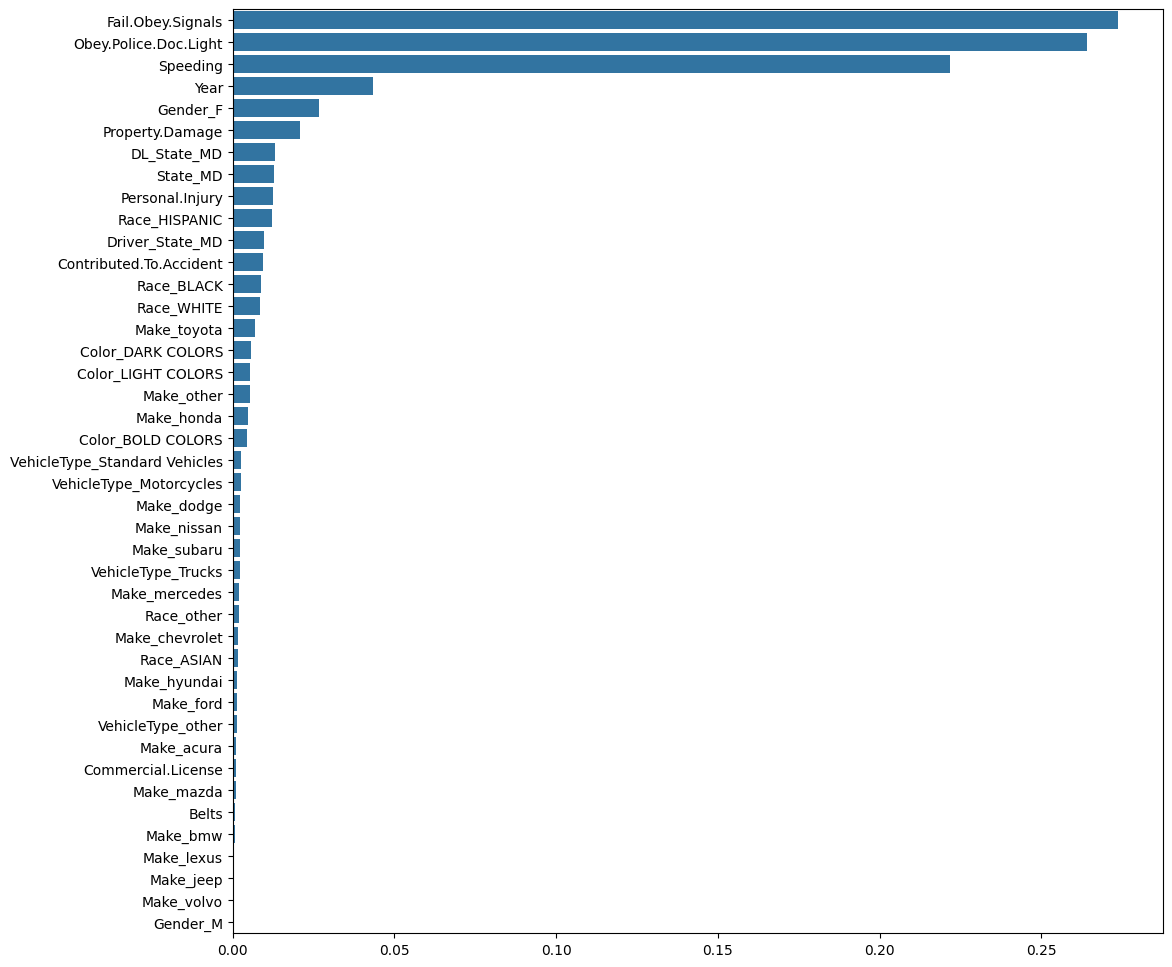

In [8]:
plt.figure(figsize=(12, 12))
plot_bar(dict(sorted(res.items(), key=lambda x: -x[1])), orient="h")
plt.savefig(fname="shap_barplot.png", dpi=300)

### Local explanation

In [9]:
res = shap_explainer.get_shap_explanation(X_test[:1000])

100%|██████████| 1000/1000 [01:18<00:00, 12.68it/s]


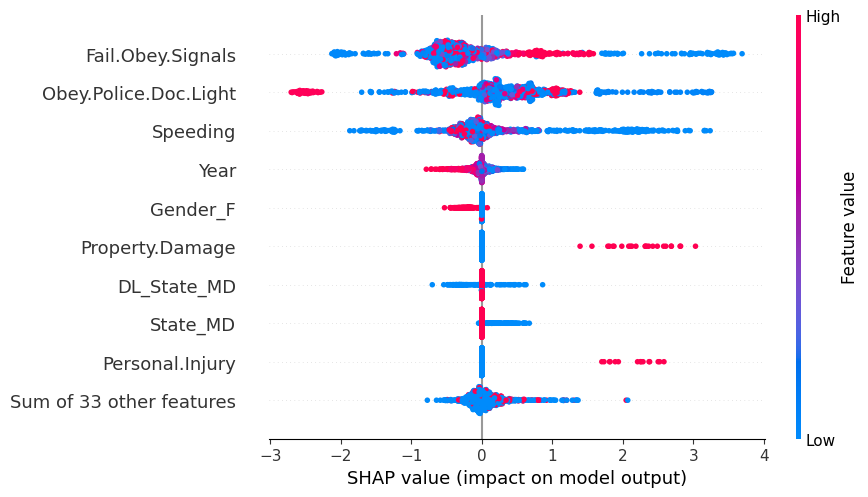

In [10]:
shap.plots.beeswarm(res)